In [11]:
import os

import keras.src.utils
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt


In [31]:
num_skipped = 0

for folder_name in ('Cat', 'Dog'):
    folder_path = os.path.join('PetImages', folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, 'rb')
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()


        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)


print(f"Delete {num_skipped} files")

Delete 1590 files


In [32]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


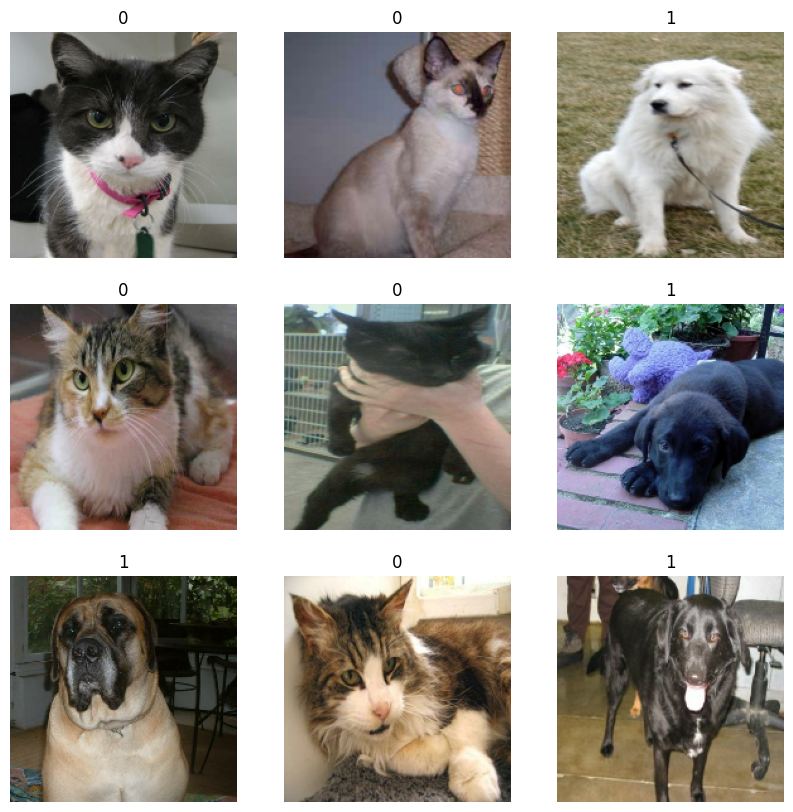

In [33]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(10):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [34]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(image):
    for layer in data_augmentation_layers:
        images = layer(image)
    return images


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
2025-03-29 17:32:25.158185: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


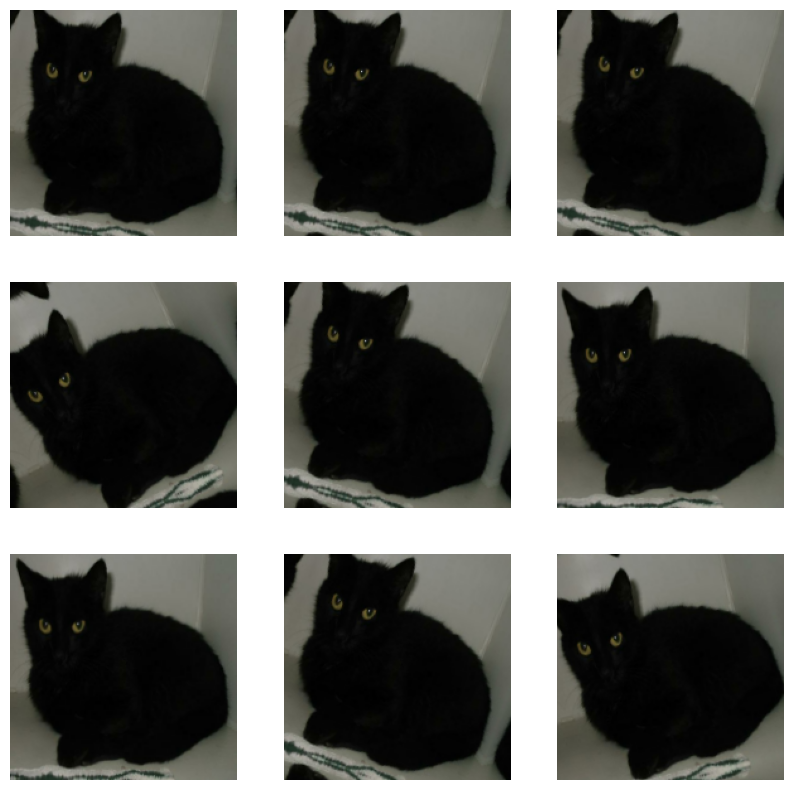

In [35]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(10):
    for i in range(9):
        augmentation = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmentation[0]).astype("uint8"))
        plt.axis("off")

In [36]:
train_ds = train_ds.map(
    lambda image, label: (data_augmentation(image), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [37]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activations = x

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(
            size, 1, strides=2, padding="same",
        ) (previous_block_activations)

        x = layers.add([x, residual])
        previous_block_activations = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        untis = 1
    else:
        untis = num_classes

    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(untis, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3, ), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [38]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("saved_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
E0000 00:00:1743269601.525773    7339 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1743269601.658692    7339 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2025-03-29 17:33:21.672479: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at xla_ops.cc:591 : FAILED_PRE

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_3331/643181573.py", line 12, in <module>

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/cohben/.virtualenvs/Tensor_Flow/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_74299]